## Time Series Movement Prediction

* With the data provided by sensonrs, it's trying to predict whether the person moved or not.
* Detailed data description & data download can be found here: https://archive.ics.uci.edu/ml/datasets/Indoor+User+Movement+Prediction+from+RSS+data
* The paper: https://www.researchgate.net/publication/257435359_An_experimental_characterization_of_reservoir_computing_in_ambient_assisted_living_applications

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np

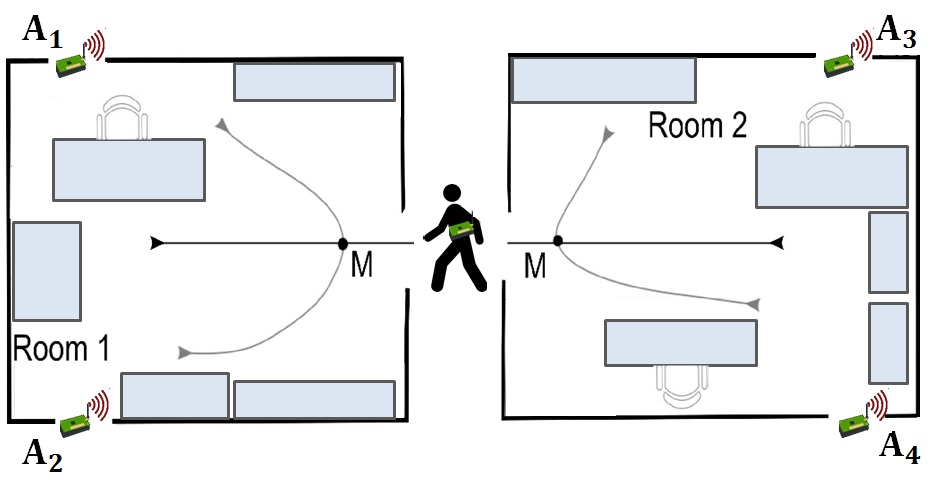

In [13]:
path="MovementAAL.jpg"
Image(path, width=600, height=400)

### Data Exploration

In [16]:
# The data has been collected from 4 sensors each second
sample_df = pd.read_csv('dataset/MovementAAL_RSS_1.csv')
sample_df.head()

,#RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [24]:
# 1 means has movement, -1 means no
## 314 records, each is for one MovementAAL_RSS file (314 files in total)

target = pd.read_csv('dataset/MovementAAL_target.csv')
print(target[' class_label'].value_counts())
target.head()

 1    158
-1    156
Name:  class_label, dtype: int64


,#sequence_ID,class_label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [29]:
# groups seperate all the 314 files into 3 groups, based on 6 types of the movement paths
# We can use group 2 as training data, group 1 as validation data and group 3 as testing data

groups = pd.read_csv('groups/MovementAAL_DatasetGroup.csv')
print(groups[' dataset_ID'].value_counts())
groups.head()

2    106
3    104
1    104
Name:  dataset_ID, dtype: int64


,#sequence_ID,dataset_ID
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


6 Paths


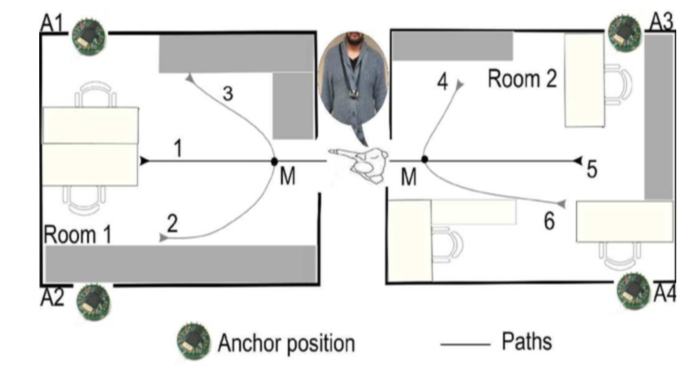

In [31]:
print('6 Paths')
path="6paths.png"
Image(path, width=500, height=300)

3 Groups


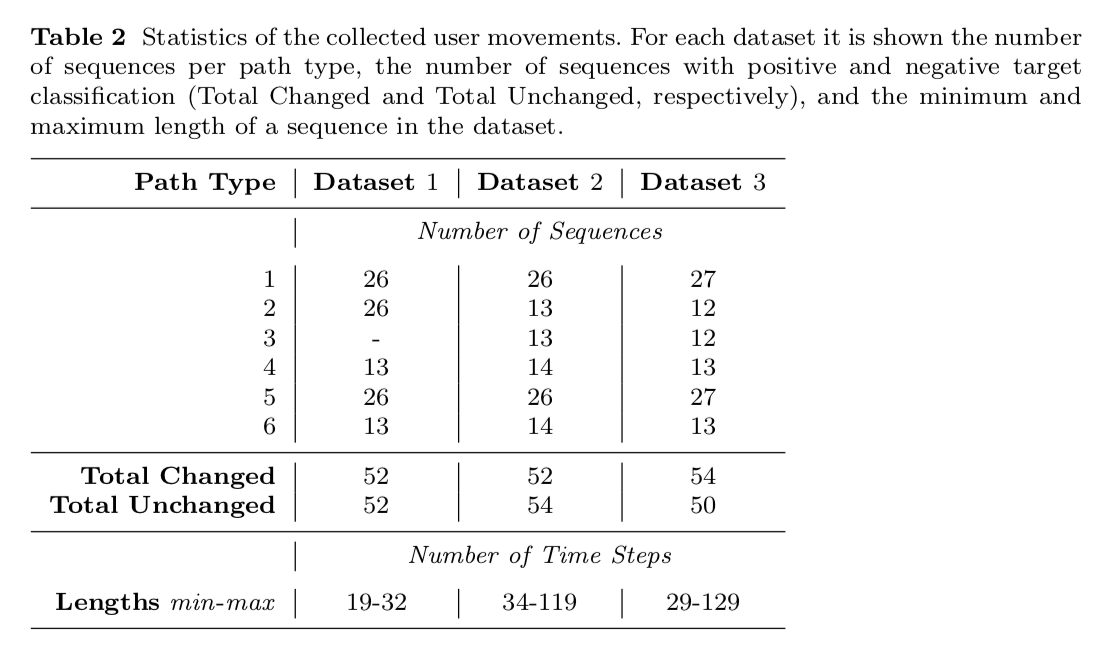

In [32]:
print('3 Groups')
path="3groups.png"
Image(path, width=500, height=300)

### Data Preprocessing

In [2]:
# There are 314 time series data files in total, let's collect them in a list
file_lst = []

ts_folder = 'dataset/'
for i in range(314):
    file_path = ts_folder + 'MovementAAL_RSS_'+str(i+1)+'.csv'
    tmp_df = pd.read_csv(file_path)
    file_lst.append(tmp_df.values)  # append each file into the list

In [3]:
file_lst[0]

array([[-0.90476 , -0.48    ,  0.28571 ,  0.3     ],
       [-0.57143 , -0.32    ,  0.14286 ,  0.3     ],
       [-0.38095 , -0.28    , -0.14286 ,  0.35    ],
       [-0.28571 , -0.2     , -0.47619 ,  0.35    ],
       [-0.14286 , -0.2     ,  0.14286 , -0.2     ],
       [-0.14286 , -0.2     ,  0.047619,  0.      ],
       [-0.14286 , -0.16    , -0.38095 ,  0.2     ],
       [-0.14286 , -0.04    , -0.61905 , -0.2     ],
       [-0.095238, -0.08    ,  0.14286 , -0.55    ],
       [-0.047619,  0.04    , -0.095238,  0.05    ],
       [-0.19048 , -0.04    ,  0.095238,  0.4     ],
       [-0.095238, -0.04    , -0.14286 ,  0.35    ],
       [-0.33333 , -0.08    , -0.28571 , -0.2     ],
       [-0.2381  ,  0.04    ,  0.14286 ,  0.35    ],
       [ 0.      ,  0.08    ,  0.14286 ,  0.05    ],
       [-0.095238,  0.04    ,  0.095238,  0.1     ],
       [-0.14286 , -0.2     ,  0.14286 ,  0.5     ],
       [-0.19048 ,  0.04    , -0.42857 ,  0.3     ],
       [-0.14286 , -0.08    , -0.2381  ,  0.15

In [4]:
# most anonying part - make each file the same length
## All pad last row to the max file length, then all truncate to 90th percentile length

# find 90th percentile & max length
file_len_lst = [len(f) for f in file_lst]
print(pd.Series(file_len_lst).describe())
print(pd.Series(file_len_lst).quantile(0.9))  # 90th percentile length

count    314.000000
mean      42.028662
std       16.185303
min       19.000000
25%       26.000000
50%       41.000000
75%       56.000000
max      129.000000
dtype: float64
61.0


In [5]:
# For each file, keep padding the last row till reach to max length 129
max_len = int(pd.Series(file_len_lst).describe()['max'])
print(max_len)

for i in range(len(file_lst)):
    original_len = len(file_lst[i])
    add_len = max_len - original_len
    
    for j in range(add_len):
        file_lst[i] = np.vstack((file_lst[i], file_lst[i][-1]))  # pad the last row towards the max length
        
print(len(file_lst[0]), len(file_lst[-1]))

129
(129, 129)


In [6]:
# Now truncate each sequence to 90th percentile length, 
## so that we can keep a balance between losing data and adding too much data
from keras.preprocessing import sequence

seq_len = 60
final_seq = sequence.pad_sequences(file_lst, maxlen=seq_len, padding='post', dtype='float', truncating='post')
print(len(final_seq), len(final_seq[0]))

Using TensorFlow backend.


(314, 60)


In [7]:
# get the labels and save as numpy array
label_df = pd.read_csv('dataset/MovementAAL_target.csv')
labels = label_df.values[:,1]
labels

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [10]:
# We can set group 2 as training, group 1 as validation set and group 3 as testing data
groups = pd.read_csv('groups/MovementAAL_DatasetGroup.csv')
print(groups[' dataset_ID'].value_counts())
groups.head()

2    106
3    104
1    104
Name:  dataset_ID, dtype: int64


,#sequence_ID,dataset_ID
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [16]:
groups.values[1]

array([2, 1])

In [34]:
train_data = [final_seq[i] for i in range(len(final_seq)) if groups.values[i][1] == 2]
val_data = [final_seq[i] for i in range(len(final_seq)) if groups.values[i][1] == 1]
test_data = [final_seq[i] for i in range(len(final_seq)) if groups.values[i][1] == 3]

In [35]:
train_labels = [labels[i] for i in range(len(final_seq)) if groups.values[i][1] == 2]
val_labels = [labels[i] for i in range(len(final_seq)) if groups.values[i][1] == 1]
test_labels = [labels[i] for i in range(len(final_seq)) if groups.values[i][1] == 3]

In [36]:
train = np.array(train_data)
val = np.array(val_data)
test = np.array(test_data)

In [38]:
print(train.shape)  # 106 files, each file has length 60, each record contains 4 values
train[0][0]

(106, 60, 4)


array([ 0.066667,  0.38462 , -1.      , -0.61905 ])

In [39]:
train_target = np.array(train_labels)
val_target = np.array(val_labels)
test_target = np.array(test_labels)
print(train_target.shape)

(106,)


In [40]:
# for target, have to convert to 0,1
train_target = (train_target + 1)/2
val_target = (val_target + 1)/2
test_target = (test_target + 1)/2

## Model Prediction

* Use sequence model LSTM

In [41]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, 4)))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [44]:
adam = Adam(lr=0.001)
# with check point, the training will stop at optimized testing results, reducing overfitting
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(val,val_target))

Train on 106 samples, validate on 104 samples
Epoch 1/200
106/106 [==============================] - 2s 18ms/step - loss: 0.6960 - acc: 0.4623 - val_loss: 0.6859 - val_acc: 0.5096

Epoch 00001: val_acc improved from -inf to 0.50962, saving model to best_model.pkl
Epoch 2/200
106/106 [==============================] - 0s 5ms/step - loss: 0.6835 - acc: 0.5849 - val_loss: 0.6758 - val_acc: 0.5481

Epoch 00002: val_acc improved from 0.50962 to 0.54808, saving model to best_model.pkl
Epoch 3/200
106/106 [==============================] - 0s 5ms/step - loss: 0.6723 - acc: 0.6132 - val_loss: 0.6669 - val_acc: 0.5865

Epoch 00003: val_acc improved from 0.54808 to 0.58654, saving model to best_model.pkl
Epoch 4/200
106/106 [==============================] - 1s 5ms/step - loss: 0.6618 - acc: 0.6226 - val_loss: 0.6572 - val_acc: 0.5769

Epoch 00004: val_acc did not improve from 0.58654
Epoch 5/200
106/106 [==============================] - 1s 5ms/step - loss: 0.6486 - acc: 0.6415 - val_loss: 0.64


Epoch 00044: val_acc did not improve from 0.62500
Epoch 45/200
106/106 [==============================] - 0s 5ms/step - loss: 0.2999 - acc: 0.8491 - val_loss: 1.2565 - val_acc: 0.5577

Epoch 00045: val_acc did not improve from 0.62500
Epoch 46/200
106/106 [==============================] - 1s 5ms/step - loss: 0.2996 - acc: 0.8585 - val_loss: 1.2424 - val_acc: 0.5577

Epoch 00046: val_acc did not improve from 0.62500
Epoch 47/200
106/106 [==============================] - 1s 5ms/step - loss: 0.2934 - acc: 0.8679 - val_loss: 1.1959 - val_acc: 0.5481

Epoch 00047: val_acc did not improve from 0.62500
Epoch 48/200
106/106 [==============================] - 1s 5ms/step - loss: 0.2758 - acc: 0.8962 - val_loss: 1.1527 - val_acc: 0.5673

Epoch 00048: val_acc did not improve from 0.62500
Epoch 49/200
106/106 [==============================] - 0s 5ms/step - loss: 0.2532 - acc: 0.9057 - val_loss: 1.1513 - val_acc: 0.5769

Epoch 00049: val_acc did not improve from 0.62500
Epoch 50/200
106/106 [==

106/106 [==============================] - 1s 5ms/step - loss: 0.2385 - acc: 0.8774 - val_loss: 2.0934 - val_acc: 0.5673

Epoch 00089: val_acc did not improve from 0.62500
Epoch 90/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2506 - acc: 0.8774 - val_loss: 2.0858 - val_acc: 0.5673

Epoch 00090: val_acc did not improve from 0.62500
Epoch 91/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2572 - acc: 0.8774 - val_loss: 1.8908 - val_acc: 0.5673

Epoch 00091: val_acc did not improve from 0.62500
Epoch 92/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2583 - acc: 0.8774 - val_loss: 1.7063 - val_acc: 0.5673

Epoch 00092: val_acc did not improve from 0.62500
Epoch 93/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2675 - acc: 0.8774 - val_loss: 1.6648 - val_acc: 0.5962

Epoch 00093: val_acc did not improve from 0.62500
Epoch 94/200
106/106 [==============================] - 1s 5ms/step - loss: 0.2792 - acc


Epoch 00132: val_acc did not improve from 0.77885
Epoch 133/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2711 - acc: 0.8962 - val_loss: 2.3682 - val_acc: 0.6058

Epoch 00133: val_acc did not improve from 0.77885
Epoch 134/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2582 - acc: 0.9151 - val_loss: 2.3142 - val_acc: 0.6058

Epoch 00134: val_acc did not improve from 0.77885
Epoch 135/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2797 - acc: 0.9057 - val_loss: 2.5222 - val_acc: 0.5673

Epoch 00135: val_acc did not improve from 0.77885
Epoch 136/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2487 - acc: 0.9151 - val_loss: 2.6836 - val_acc: 0.5577

Epoch 00136: val_acc did not improve from 0.77885
Epoch 137/200
106/106 [==============================] - 0s 4ms/step - loss: 0.2452 - acc: 0.8962 - val_loss: 2.7752 - val_acc: 0.5481

Epoch 00137: val_acc did not improve from 0.77885
Epoch 138/200
106/1

106/106 [==============================] - 1s 6ms/step - loss: 0.1433 - acc: 0.9528 - val_loss: 2.2738 - val_acc: 0.5673

Epoch 00177: val_acc did not improve from 0.77885
Epoch 178/200
106/106 [==============================] - 1s 6ms/step - loss: 0.1396 - acc: 0.9528 - val_loss: 2.1070 - val_acc: 0.6058

Epoch 00178: val_acc did not improve from 0.77885
Epoch 179/200
106/106 [==============================] - 1s 6ms/step - loss: 0.1282 - acc: 0.9528 - val_loss: 1.9549 - val_acc: 0.6346

Epoch 00179: val_acc did not improve from 0.77885
Epoch 180/200
106/106 [==============================] - 1s 6ms/step - loss: 0.1212 - acc: 0.9623 - val_loss: 1.8653 - val_acc: 0.6442

Epoch 00180: val_acc did not improve from 0.77885
Epoch 181/200
106/106 [==============================] - 1s 6ms/step - loss: 0.1171 - acc: 0.9623 - val_loss: 1.8829 - val_acc: 0.6250

Epoch 00181: val_acc did not improve from 0.77885
Epoch 182/200
106/106 [==============================] - 1s 6ms/step - loss: 0.1041 

In [45]:
model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

0.6057692307692307